# First Place - Single Model - LB 38.81
I'm excited to share my `First Place - Gold Medal - Single Model` solution in Kaggle's playground backpack prediction competition. We begin with my starter notebook [here][1] and then we add more engineered features using [RAPIDS cuDF-Pandas][2]. The notebook you are reading has 138 features. This is a simplfied version of my actual final solution which has 500 features! None-the-less, the notebook you are reading achieves first place accuracy!

A simple way to boost the performance of the notebook you are reading is to train 20 folds inside 20 folds instead of 7 inside 7 (or 10 in 10, or 15 in 15). And we can decrease XGBoost learning rate from 0.01 to 0.005 (and change early stopping to 1000). This will of course increase runtime but it will also improve model accuracy too!

Another way to boost this notebook's accuracy is to include the additional 362 features from my actual final solution. The text below is the introduction from my original starter notebook:

[1]: https://www.kaggle.com/code/cdeotte/feature-engineering-with-rapids-lb-38-847
[2]: https://rapids.ai/cudf-pandas/

# Feature Engineering with Fast cuDF-Pandas!
One of the most powerful feature engineering techniques is `groupby(COL1)[COL2].agg(STAT)`. This is where we group by `COL1` column and aggregate (i.e. compute) a statistic `STAT` over another column `COL2`. This is the underlying method to compute `target encoding` and `count encoding`. By computing raw statistics and inputting them into our model, our model can do more than only receiving `TE` or `CE`. This notebook illustrates creating 50 engineered features, but we can create hundreds more and improve CV score and LB score!

When our dataset has millions of rows like Kaggle's Backpack competition, then `groupby` operations take time to compute. The fastest way to compute a `groupby` aggregation is to use GPU with [RAPIDS cuDF-Pandas][1] library.

There are two ways to use [RAPIDS cuDF][2]. We can write cuDF code which looks just like Pandas code and starts with `import cudf`. Or we can write normal Pandas code with `import pandas` but before that we add the cell magic command `%load_ext cudf.pandas`. By adding this magic command all calls to Pandas afterward will use [RAPIDS cuDF][2] behind the scenes taking advantage of the massive speed boost of GPU!

Alternatively, we can use [cuDF-Polars][3]. To use [cuDF-Polars][3], we write Polars code with lazy frame. Then the final call includes `.collect(engine="gpu")` which will run all previous Polars code behind the scenes with [RAPIDS cuDF][2].

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://rapids.ai/polars-gpu-engine/

# RAPIDS v25.02
[RAPIDS v25.02][1] was just released Feb 15, 2025! Instructions on installing RAPIDS is [here][1]. On Kaggle, the easiest way to pip install new libraries is to do it once in a `Utility Script` notebook. Then whenever we attach the `Utility Script` notebook to another Kaggle notebook, the second Kaggle notebook immediately gets the benefit of the pip installed libraries. We created a [RAPIDS 25.02][1] `Utility Script` [here][2], and we attach it to the notebook you are reading. Therefore the notebook you are reading can import RAPIDS v25.02 without needing to pip install!

[1]: https://docs.rapids.ai/install/
[2]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

# GPU Acceleration
We activate [cuDF-Pandas][1] with the magic command `%load_ext cudf.pandas` below. Afterward, all calls to Pandas will use fast GPU [RAPIDS cuDF][2] behind the scenes! Since we attached `Utility Script` notebook [here][3] to the notebook you are reading, we will be using the new [RAPIDS v25.02][2]!

[1]: https://rapids.ai/cudf-pandas/
[2]: https://docs.rapids.ai/install/
[3]: https://www.kaggle.com/code/cdeotte/rapids-cudf-25-02-cuml-25-02

In [1]:
%load_ext cudf.pandas

import numpy as np, pandas as pd, gc
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

VER=1

# Load Data
We load train, train extra, and test data. The combined train data has 4 million rows! This means we do not need to fear overfitting train. We can make hundreds/thousands of new features and every time our CV improves our LB will improve too!

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
print("Train shape", train.shape )
train.head()

Train shape (300000, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [3]:
train2 = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")
print("Extra Train shape", train2.shape )
train2.head()

Extra Train shape (3694318, 11)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [4]:
train = pd.concat([train,train2],axis=0,ignore_index=True)
print("Combined Train shape", train.shape)

Combined Train shape (3994318, 11)


In [5]:
test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
print("Test shape", test.shape )
test.head()

Test shape (200000, 10)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,<NA>,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


# Feature Engineer Columns

First we will engineer 8 new columns by combining each categorical column with Weight Capacity as was done in my starter notebook. Next we engineer 63 more columns listed below:
* One column to indicate all NANs using a base-2 encoding
* NANs per feature combined with Weight Capacity
* Bin Weight Capacity by rounding it in different ways
* Merge original dataset price
* Extract digits from Weight Capacity
* Combine digit features
* Combine original categorical columns

In [6]:
CATS = list(train.columns[1:-2])
print(f"There are {len(CATS)} categorical columns:")
print( CATS )
print(f"There are 1 numerical column:")
print( ["Weight Capacity (kg)"] )

There are 8 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
There are 1 numerical column:
['Weight Capacity (kg)']


In [7]:
COMBO = ["NaNs"]
train["NaNs"] = np.float32(0)
test["NaNs"] = np.float32(0)

for i,c in enumerate(CATS):

    # NEW FEATURE - ENCODE ALL NAN AS ONE BASE-2 FEATURE
    train["NaNs"] += train[c].isna()*2**i
    test["NaNs"] += test[c].isna()*2**i

    # NEW FEATURE - COMBINE EACH COLUMN'S NAN WITH WEIGHT CAPACITY
    n = f"{c}_nan_wc"
    train[n] = train[c].isna()*100 + train["Weight Capacity (kg)"]
    test[n] = test[c].isna()*100 + test["Weight Capacity (kg)"]
    COMBO.append(n)
    
    combine = pd.concat([train[c],test[c]],axis=0)
    combine,_ = pd.factorize(combine)
    train[c] = combine[:len(train)].astype("float32")
    test[c] = combine[len(train):].astype("float32")
    n = f"{c}_wc"
    train[n] = train[c]*100 + train["Weight Capacity (kg)"]
    test[n] = test[c]*100 + test["Weight Capacity (kg)"]
    COMBO.append(n)

In [8]:
# NEW FEATURE - BIN WEIGHT CAPACITY USING ROUNDING
for k in range(7,10):
    n = f"round{k}"
    train[n] = train["Weight Capacity (kg)"].round(k)
    test[n] = test["Weight Capacity (kg)"].round(k)
    COMBO.append(n)

In [9]:
# NEW FEATURE - ORIGINAL DATASET PRICE
NEW_COLS = []
orig = pd.read_csv("/kaggle/input/student-bag-price-prediction-dataset/Noisy_Student_Bag_Price_Prediction_Dataset.csv")
tmp = orig.groupby("Weight Capacity (kg)").Price.mean()
tmp.name = "orig_price"
train = train.merge(tmp, on="Weight Capacity (kg)", how="left")
test = test.merge(tmp, on="Weight Capacity (kg)", how="left")
NEW_COLS.append("orig_price")

In [10]:
# NEW FEATURE - ORIGINAL DATASET PRICE FROM ROUNDED WEIGHT CAPACITY 
for k in range(7,10):
    n = f"round{k}"
    orig[n] = orig["Weight Capacity (kg)"].round(k)
    tmp = orig.groupby(n).Price.mean()
    tmp.name = f"orig_price_r{k}"
    train = train.merge(tmp, on=n, how="left")
    test = test.merge(tmp, on=n, how="left")
    NEW_COLS.append(f"orig_price_r{k}")

In [11]:
# NEW FEATURE - DIGIT EXTRACTION FROM WEIGHT CAPACITY
for k in range(1,10):
    train[f'digit{k}'] = ((train['Weight Capacity (kg)'] * 10**k) % 10).fillna(-1).astype("int8")
    test[f'digit{k}'] = ((test['Weight Capacity (kg)'] * 10**k) % 10).fillna(-1).astype("int8")
DIGITS = [f"digit{k}" for k in range(1,10)]

In [12]:
# NEW FEATURE - COMBINATIONS OF DIGITS 
for i in range(4):
    for j in range(i+1,5):
        n = f"digit_{i+1}_{j+1}"
        train[n] = ((train[f'digit{i+1}']+1)*11 + train[f'digit{j+1}']+1).astype("int8")
        test[n] = ((test[f'digit{i+1}']+1)*11 + test[f'digit{j+1}']+1).astype("int8")
        COMBO.append(n)

In [13]:
# NEW FEATURE - COMBINATIONS OF CATS
PAIRS = []
for i,c1 in enumerate(CATS[:-1]):
    for j,c2 in enumerate(CATS[i+1:]):
        n = f"{c1}_{c2}"
        m1 = train[c1].max()+1
        m2 = train[c2].max()+1
        train[n] = ((train[c1]+1 + (train[c2]+1)/(m2+1))*(m2+1)).astype("int8")
        test[n] = ((test[c1]+1 + (test[c2]+1)/(m2+1))*(m2+1)).astype("int8")
        COMBO.append(n)
        PAIRS.append(n)

In [14]:
print(f"New Train shape:", train.shape )
train.head()

New Train shape: (3994318, 82)


,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,NaNs,Brand_nan_wc,Brand_wc,Material_nan_wc,Material_wc,Size_nan_wc,Size_wc,Compartments_nan_wc,Compartments_wc,Laptop Compartment_nan_wc,Laptop Compartment_wc,Waterproof_nan_wc,Waterproof_wc,Style_nan_wc,Style_wc,Color_nan_wc,Color_wc,round7,round8,round9,orig_price,orig_price_r7,orig_price_r8,orig_price_r9,digit1,digit2,digit3,digit4,digit5,digit6,digit7,digit8,digit9,digit_1_2,digit_1_3,digit_1_4,digit_1_5,digit_2_3,digit_2_4,digit_2_5,digit_3_4,digit_3_5,digit_4_5,Brand_Material,Brand_Size,Brand_Compartments,Brand_Laptop Compartment,Brand_Waterproof,Brand_Style,Brand_Color,Material_Size,Material_Compartments,Material_Laptop Compartment,Material_Waterproof,Material_Style,Material_Color,Size_Compartments,Size_Laptop Compartment,Size_Waterproof,Size_Style,Size_Color,Compartments_Laptop Compartment,Compartments_Waterproof,Compartments_Style,Compartments_Color,Laptop Compartment_Waterproof,Laptop Compartment_Style,Laptop Compartment_Color,Waterproof_Style,Waterproof_Color,Style_Color
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.611723,112.15875,0.0,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,11.611723,39.7705548,39.7705548,39.7705548,39.7705548,6,1,1,7,2,2,8,0,5,79,79,85,80,24,30,25,30,25,91,6,5,12,4,4,5,8,5,12,4,4,5,8,12,4,4,5,8,4,4,5,8,4,5,8,5,8,8
1,1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,27.078537,68.88056,0.0,27.078537,27.078537,27.078537,127.078537,27.078537,127.078537,27.078537,127.078537,27.078537,27.078537,27.078537,127.078537,27.078537,127.078537,27.078537,127.078537,27.078537,27.078537,27.078537,<NA>,<NA>,<NA>,<NA>,0,7,8,5,3,6,5,8,0,19,20,17,15,97,94,92,105,103,70,7,6,13,4,5,6,9,10,24,7,8,10,16,24,7,8,10,16,7,8,10,16,5,6,9,10,16,16
2,2,1.0,0.0,1.0,2.0,0.0,0.0,1.0,2.0,16.643760,39.17320,0.0,16.643760,116.643760,16.643760,16.643760,16.643760,116.643760,16.643760,216.643760,16.643760,16.643760,16.643760,16.643760,16.643760,116.643760,16.643760,216.643760,16.643760,16.643760,16.643760,<NA>,<NA>,<NA>,<NA>,6,4,3,7,5,9,9,4,9,82,81,85,83,59,63,61,52,50,94,11,10,25,7,7,10,17,6,14,4,4,6,10,25,7,7,10,17,10,10,14,24,4,6,10,6,10,17
3,3,2.0,2.0,1.0,3.0,0.0,0.0,1.0,1.0,12.937220,80.60793,0.0,12.937220,212.937220,12.937220,212.937220,12.937220,112.937220,12.937220,312.937220,12.937220,12.937220,12.937220,12.937220,12.937220,112.937220,12.937220,112.937220,12.937220,12.937220,12.937220,<NA>,<NA>,<NA>,<NA>,9,3,7,2,2,0,3,0,6,114,118,113,113,52,47,47,91,91,36,18,14,37,10,10,14,23,14,37,10,10,14,23,26,7,7,10,16,13,13,18,30,4,6,9,6,9,16
4,4,3.0,1.0,0.0,4.0,0.0,1.0,1.0,1.0,17.749338,86.02312,0.0,17.749338,317.749338,17.749338,117.749338,17.749338,17.749338,17.749338,417.749338,17.749338,17.749338,17.749338,117.749338,17.749338,117.749338,17.749338,117.749338,17.749339,17.749338,17.749338,<NA>,<NA>,<NA>,<NA>,7,4,9,3,3,8,4,6,5,93,98,92,92,65,59,59,114,114,48,22,17,49,13,14,18,30,9,27,7,8,10,16,16,4,5,6,9,16,17,22,37,5,6,9,10,16,16


In [15]:
FEATURES = CATS + ["Weight Capacity (kg)"] + COMBO + DIGITS + NEW_COLS
print(f"We now have {len(FEATURES)} columns:")
print( FEATURES )

We now have 80 columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'NaNs', 'Brand_nan_wc', 'Brand_wc', 'Material_nan_wc', 'Material_wc', 'Size_nan_wc', 'Size_wc', 'Compartments_nan_wc', 'Compartments_wc', 'Laptop Compartment_nan_wc', 'Laptop Compartment_wc', 'Waterproof_nan_wc', 'Waterproof_wc', 'Style_nan_wc', 'Style_wc', 'Color_nan_wc', 'Color_wc', 'round7', 'round8', 'round9', 'digit_1_2', 'digit_1_3', 'digit_1_4', 'digit_1_5', 'digit_2_3', 'digit_2_4', 'digit_2_5', 'digit_3_4', 'digit_3_5', 'digit_4_5', 'Brand_Material', 'Brand_Size', 'Brand_Compartments', 'Brand_Laptop Compartment', 'Brand_Waterproof', 'Brand_Style', 'Brand_Color', 'Material_Size', 'Material_Compartments', 'Material_Laptop Compartment', 'Material_Waterproof', 'Material_Style', 'Material_Color', 'Size_Compartments', 'Size_Laptop Compartment', 'Size_Waterproof', 'Size_Style', 'Size_Color', 'Compartments_Laptop Compartment', 'Compartment

# XGBoost with Feature Engineer GroupBy
We train XGBoost with nested folds. We use the inner nested fold to create new features that aggregate the target `price`. We must do this to prevent target leakage. And we use the outer fold to create new features that do not aggregate the target `price`. In each k fold loop, we engineer new features using the advanced feature engineering technique `groupby(COL1)[COL2].agg(STAT)`. Since we are using [RAPIDS cuDF-Pandas][1], these groupby computations will run fast on GPU! And we will train our model quickly on GPU using XGBoost!

**NEW FEATURES** Compared with our starter notebook, we add two new types of aggregations. Namely we groupby and compute quantiles. And we groupby and compute histogram bin counts! We also create two new division features. We divide aggregated count by nunique. And we divide aggregated std by count. (We also removed some features from my starter notebook which saves memory).

**UPDATE** We reduce all engineered features to `float32` to reduce memory usage. (But we keep original column Weight Capacity (and it's combinations) as `float64` so as not to lose the original digits). 

[1]: https://rapids.ai/cudf-pandas/

In [16]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
print(f"XGBoost version",xgb.__version__)

XGBoost version 2.0.3


In [17]:
# STATISTICS TO AGGEGATE FOR OUR FEATURE GROUPS
STATS = ["mean","std","count","nunique","median","min","max","skew"]
STATS2 = ["mean"]

In [18]:
# QUANTILES AND HISTOGRAM BINS TO AGGREGATE
BINS=10
QUANTILES = [5,10,40,45,55,60,90,95]
def make_histogram(prices, bins=BINS, range_min=15, range_max=150):
    hist, _ = np.histogram(prices, bins=bins, range=(range_min, range_max))
    return hist

In [19]:
%%time

FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

# OUTER K FOLD
for i, (train_index, test_index) in enumerate(kf.split(train)):
    print(f"### OUTER Fold {i+1} ###")

    X_train = train.loc[train_index,FEATURES+['Price']].reset_index(drop=True).copy()
    y_train = train.loc[train_index,'Price']

    X_valid = train.loc[test_index,FEATURES].reset_index(drop=True).copy()
    y_valid = train.loc[test_index,'Price']

    X_test = test[FEATURES].reset_index(drop=True).copy()

    # INNER K FOLD (TO PREVENT LEAKAGE WHEN USING PRICE)
    kf2 = KFold(n_splits=FOLDS, shuffle=True, random_state=42)   
    for j, (train_index2, test_index2) in enumerate(kf2.split(X_train)):
        print(f" ## INNER Fold {j+1} (outer fold {i+1}) ##")

        X_train2 = X_train.loc[train_index2,FEATURES+['Price']].copy()
        X_valid2 = X_train.loc[test_index2,FEATURES].copy()

        ### FEATURE SET 1 (uses price) ###
        col = "Weight Capacity (kg)"
        tmp = X_train2.groupby(col).Price.agg(STATS)
        tmp.columns = [f"TE1_wc_{s}" for s in STATS]
        X_valid2 = X_valid2.merge(tmp, on=col, how="left")
        for c in tmp.columns:
            X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")

        ### FEATURE SET 2 (uses price) ###
        for col in COMBO:
            tmp = X_train2.groupby(col).Price.agg(STATS2)
            tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
            X_valid2 = X_valid2.merge(tmp, on=col, how="left")
            for c in tmp.columns:
                X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")

        # AGGREGATE QUANTILES (uses price)
        for k in QUANTILES:
            result = X_train2.groupby('Weight Capacity (kg)').agg({'Price': lambda x: x.quantile(k/100)})
            result.columns = [f"quantile_{k}"]
            X_valid2 = X_valid2.merge(result, on="Weight Capacity (kg)", how="left")
            X_train.loc[test_index2,f"quantile_{k}"] = X_valid2[f"quantile_{k}"].values.astype("float32")

        # AGGREGATE HISTOGRAMS (uses price)
        tmp = X_train2.loc[~X_train2.orig_price.isna()].groupby("Weight Capacity (kg)")[["Price"]].agg("count")
        tmp.columns = ['ct']
        X_train3 = X_train2.merge(tmp.loc[tmp['ct']>1],on="Weight Capacity (kg)",how="left")
        X_train3 = X_train3.loc[~X_train3['ct'].isna()]
        result = X_train3.groupby("Weight Capacity (kg)")["Price"].apply(make_histogram)
        result = result.to_frame()['Price'].apply(pd.Series)
        result.columns = [f"histogram_{x}" for x in range(BINS)]
        X_valid2 = X_valid2.merge(result, on="Weight Capacity (kg)", how="left")
        for c in [f"histogram_{x}" for x in range(BINS)]:
            X_train.loc[test_index2,c] = X_valid2[c].values.astype("float32")
            
        del result, X_train3, tmp
        del X_train2, X_valid2
        gc.collect()

    ### FEATURE SET 1 (uses price) ###
    col = "Weight Capacity (kg)"
    tmp = X_train.groupby(col).Price.agg(STATS)
    tmp.columns = [f"TE1_wc_{s}" for s in STATS]
    tmp = tmp.astype("float32")
    X_valid = X_valid.merge(tmp, on=col, how="left")
    X_test = X_test.merge(tmp, on=col, how="left")

    ### FEATURE SET 2 (uses price) ###
    for col in COMBO:
        tmp = X_train.groupby(col).Price.agg(STATS2)
        tmp.columns = [f"TE2_{col}_{s}" for s in STATS2]
        tmp = tmp.astype("float32")
        X_valid = X_valid.merge(tmp, on=col, how="left")
        X_test = X_test.merge(tmp, on=col, how="left")

    # AGGREGATE QUANTILES (uses price)
    for k in QUANTILES:
        result = X_train.groupby('Weight Capacity (kg)').agg({'Price': lambda x: x.quantile(k/100)})
        result.columns = [f"quantile_{k}"]
        result = result.astype("float32")
        X_valid = X_valid.merge(result, on="Weight Capacity (kg)", how="left")
        X_test = X_test.merge(result, on="Weight Capacity (kg)", how="left")

    # AGGREGATE HISTOGRAMS (uses price)
    tmp = X_train.loc[~X_train.orig_price.isna()].groupby("Weight Capacity (kg)")[["Price"]].agg("count")
    tmp.columns = ['ct']
    X_train3 = X_train.merge(tmp.loc[tmp['ct']>1],on="Weight Capacity (kg)",how="left")
    X_train3 = X_train3.loc[~X_train3['ct'].isna()]
    result = X_train3.groupby("Weight Capacity (kg)")["Price"].apply(make_histogram)
    result = result.to_frame()['Price'].apply(pd.Series)
    result.columns = [f"histogram_{x}" for x in range(BINS)]
    result = result.astype("float32")
    X_valid = X_valid.merge(result, on="Weight Capacity (kg)", how="left")
    X_test = X_test.merge(result, on="Weight Capacity (kg)", how="left")
    del result, X_train3, tmp

    # COUNT PER NUNIQUE
    X_train['TE1_wc_count_per_nunique'] = X_train['TE1_wc_count']/X_train['TE1_wc_nunique']
    X_valid['TE1_wc_count_per_nunique'] = X_valid['TE1_wc_count']/X_valid['TE1_wc_nunique']
    X_test['TE1_wc_count_per_nunique'] = X_test['TE1_wc_count']/X_test['TE1_wc_nunique']
    
    # STD PER COUNT
    X_train['TE1_wc_std_per_count'] = X_train['TE1_wc_std']/X_train['TE1_wc_count']
    X_valid['TE1_wc_std_per_count'] = X_valid['TE1_wc_std']/X_valid['TE1_wc_count']
    X_test['TE1_wc_std_per_count'] = X_test['TE1_wc_std']/X_test['TE1_wc_count']

    # CONVERT TO CATS SO XGBOOST RECOGNIZES THEM
    X_train[CATS+DIGITS] = X_train[CATS+DIGITS].astype("category")
    X_valid[CATS+DIGITS] = X_valid[CATS+DIGITS].astype("category")
    X_test[CATS+DIGITS] = X_test[CATS+DIGITS].astype("category")

    # DROP PRICE THAT WAS USED FOR TARGET ENCODING
    X_train = X_train.drop(['Price'],axis=1)

    # DROP NON-TE CAT PAIRS
    X_train = X_train.drop(PAIRS,axis=1)
    X_valid = X_valid.drop(PAIRS,axis=1)
    X_test = X_test.drop(PAIRS,axis=1)

    # BUILD MODEL
    model = XGBRegressor(
        device="cuda",
        max_depth=6,  
        colsample_bynode=0.3, 
        subsample=0.8,  
        n_estimators=50_000,  
        learning_rate=0.01,  
        enable_categorical=True,
        min_child_weight=10,
        early_stopping_rounds=500,
    )
    
    # TRAIN MODEL
    COLS = X_train.columns
    model.fit(
        X_train[COLS], y_train,
        eval_set=[(X_valid[COLS], y_valid)],  
        verbose=500,
    )

    # PREDICT OOF AND TEST
    oof[test_index] = model.predict(X_valid[COLS])
    pred += model.predict(X_test[COLS])

    # CLEAR MEMORY
    del X_train, X_valid, X_test
    del y_train, y_valid
    if i != FOLDS-1: del model
    gc.collect()

pred /= FOLDS

### OUTER Fold 1 ###
 ## INNER Fold 1 (outer fold 1) ##
 ## INNER Fold 2 (outer fold 1) ##
 ## INNER Fold 3 (outer fold 1) ##
 ## INNER Fold 4 (outer fold 1) ##
 ## INNER Fold 5 (outer fold 1) ##
 ## INNER Fold 6 (outer fold 1) ##
 ## INNER Fold 7 (outer fold 1) ##
[0]	validation_0-rmse:38.90439
[500]	validation_0-rmse:38.61897
[1000]	validation_0-rmse:38.60913
[1500]	validation_0-rmse:38.60571
[2000]	validation_0-rmse:38.60394
[2500]	validation_0-rmse:38.60312
[3000]	validation_0-rmse:38.60249
[3500]	validation_0-rmse:38.60205
[3796]	validation_0-rmse:38.60209


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:54:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### OUTER Fold 2 ###
 ## INNER Fold 1 (outer fold 2) ##
 ## INNER Fold 2 (outer fold 2) ##
 ## INNER Fold 3 (outer fold 2) ##
 ## INNER Fold 4 (outer fold 2) ##
 ## INNER Fold 5 (outer fold 2) ##
 ## INNER Fold 6 (outer fold 2) ##
 ## INNER Fold 7 (outer fold 2) ##
[0]	validation_0-rmse:38.90074
[500]	validation_0-rmse:38.61876
[1000]	validation_0-rmse:38.60956
[1500]	validation_0-rmse:38.60691
[2000]	validation_0-rmse:38.60608
[2500]	validation_0-rmse:38.60541
[2970]	validation_0-rmse:38.60606
### OUTER Fold 3 ###
 ## INNER Fold 1 (outer fold 3) ##
 ## INNER Fold 2 (outer fold 3) ##
 ## INNER Fold 3 (outer fold 3) ##
 ## INNER Fold 4 (outer fold 3) ##
 ## INNER Fold 5 (outer fold 3) ##
 ## INNER Fold 6 (outer fold 3) ##
 ## INNER Fold 7 (outer fold 3) ##
[0]	validation_0-rmse:38.92040
[500]	validation_0-rmse:38.62720
[1000]	validation_0-rmse:38.61792
[1500]	validation_0-rmse:38.61490
[2000]	validation_0-rmse:38.61318
[2500]	validation_0-rmse:38.61241
[3000]	validation_0-rmse:38.61191


# Overall CV Score
Below we display overall cv score and save oof predictions to disk so we can use them later to assist finding ensemble weights with our other models.

In [20]:
# COMPUTE OVERALL CV SCORE
true = train.Price.values
s = np.sqrt(np.mean( (oof-true)**2.0 ) )
print(f"=> Overall CV Score = {s}")

=> Overall CV Score = 38.632293145396204


In [21]:
# SAVE OOF TO DISK FOR ENSEMBLES
np.save(f"oof_v{VER}",oof)
print("Saved oof to disk")

Saved oof to disk


# Feature Names
Below we list all our engineered features. We are using 138 features in total!

In [22]:
print(f"\nIn total, we used {len(COLS)} features, Wow!\n")
print( list(COLS) )


In total, we used 138 features, Wow!

['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'NaNs', 'Brand_nan_wc', 'Brand_wc', 'Material_nan_wc', 'Material_wc', 'Size_nan_wc', 'Size_wc', 'Compartments_nan_wc', 'Compartments_wc', 'Laptop Compartment_nan_wc', 'Laptop Compartment_wc', 'Waterproof_nan_wc', 'Waterproof_wc', 'Style_nan_wc', 'Style_wc', 'Color_nan_wc', 'Color_wc', 'round7', 'round8', 'round9', 'digit_1_2', 'digit_1_3', 'digit_1_4', 'digit_1_5', 'digit_2_3', 'digit_2_4', 'digit_2_5', 'digit_3_4', 'digit_3_5', 'digit_4_5', 'digit1', 'digit2', 'digit3', 'digit4', 'digit5', 'digit6', 'digit7', 'digit8', 'digit9', 'orig_price', 'orig_price_r7', 'orig_price_r8', 'orig_price_r9', 'TE1_wc_mean', 'TE1_wc_std', 'TE1_wc_count', 'TE1_wc_nunique', 'TE1_wc_median', 'TE1_wc_min', 'TE1_wc_max', 'TE1_wc_skew', 'TE2_NaNs_mean', 'TE2_Brand_nan_wc_mean', 'TE2_Brand_wc_mean', 'TE2_Material_nan_wc_mean', 'TE2_Material_wc_mean'

# XGB Feature Importance
Here is top 100 XGBoost feature importance sorted by `gain`.

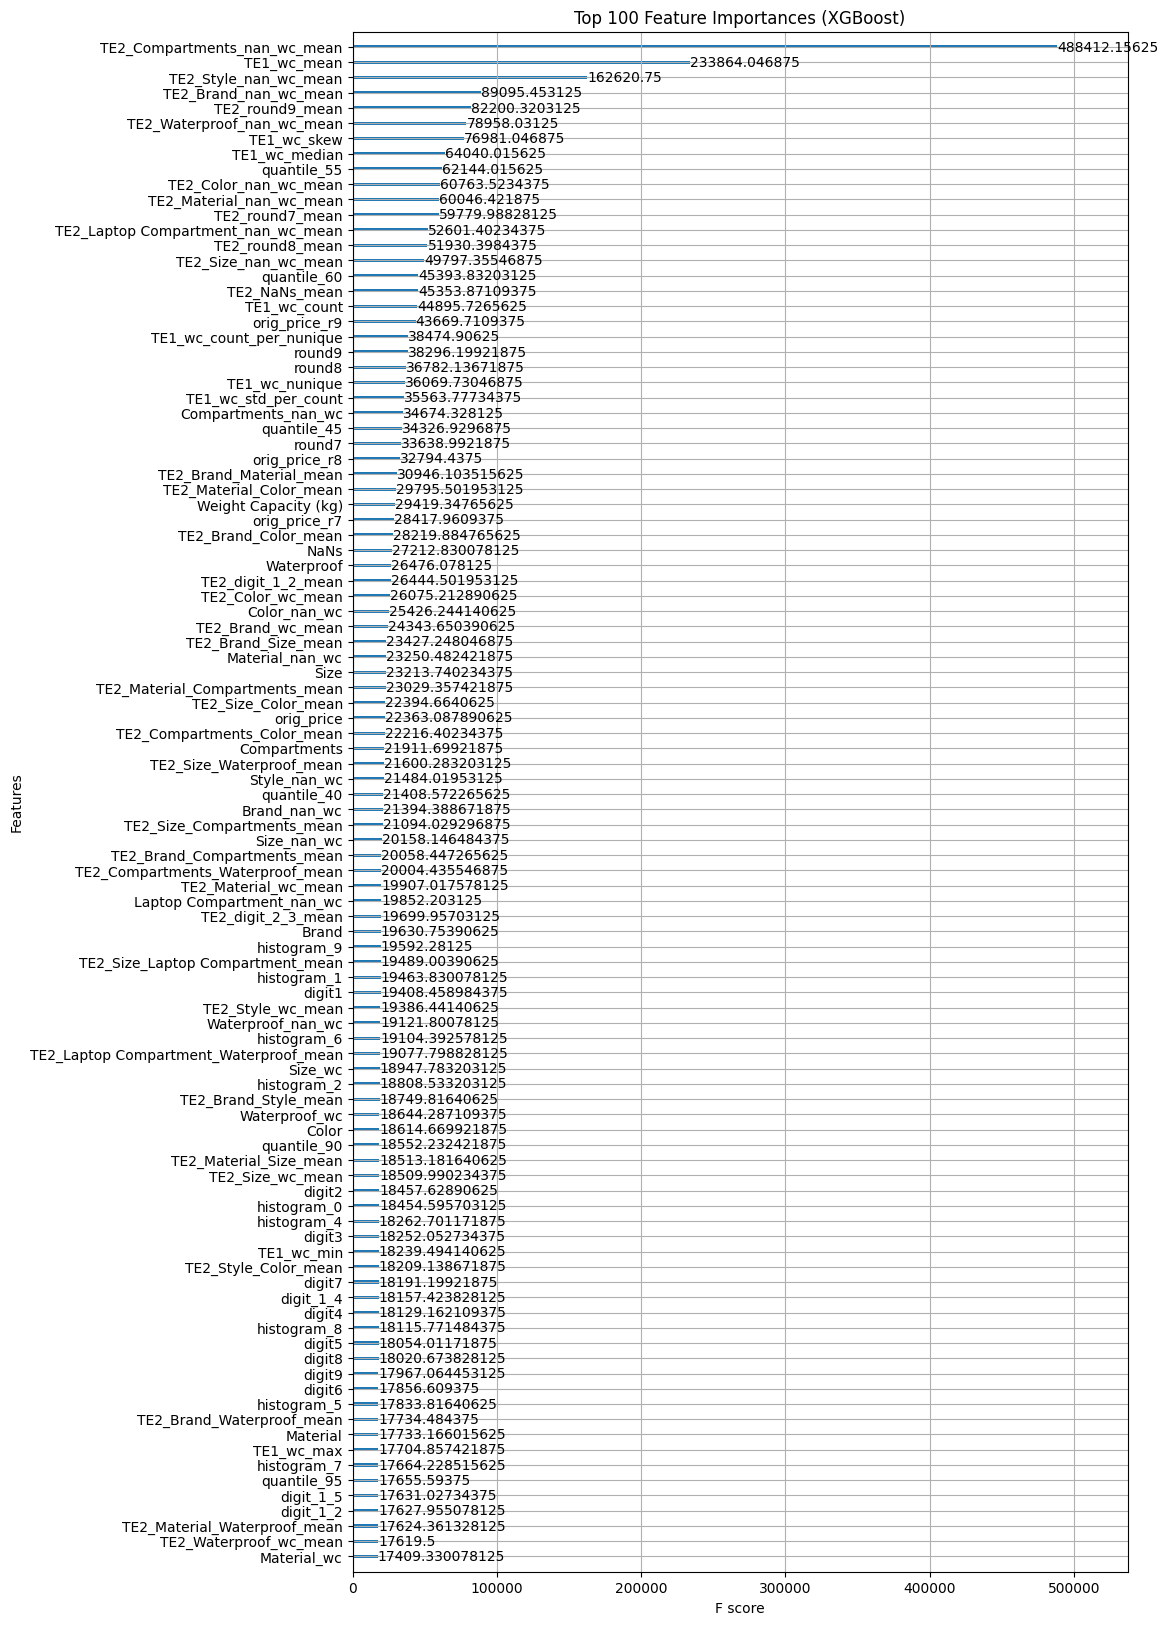

In [23]:
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=100, importance_type='gain',ax=ax)
plt.title("Top 100 Feature Importances (XGBoost)")
plt.show()

# Make Submission CSV
We save our test predictions to submission.csv and plot our predictions. 

In [24]:
sub = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

,id,Price
0,300000,80.909428
1,300001,82.847172
2,300002,87.107935
3,300003,78.165855
4,300004,80.089008


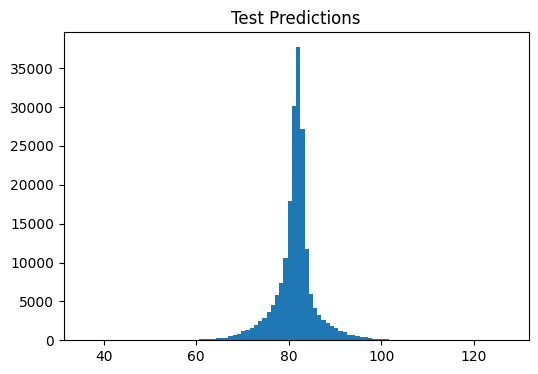

In [25]:
plt.figure(figsize=(6,4))
plt.hist(sub.Price,bins=100)
plt.title("Test Predictions")
plt.show()